# Setup

In [1]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

root_path = Path("/home/olivieri/exp").resolve()
src_path = root_path / "src"
sys.path.append(f"{str(src_path)}")

In [2]:
import pandas as pd
from glob import glob
import os
import xarray as xr

from prompter import *
from data import *

In [ ]:
# Setting
BY_MODEL = "LRASPP_MobileNet_V3"
SPLIT_BY = "non-splitted"

In [4]:
root_exp_name = "test_resized"

In [ ]:
root_exp_path = get_selected_annots_path(BY_MODEL, SPLIT_BY) / "eval_prs" / root_exp_name

exps_path = glob(f"{root_exp_path}/*")
exps_names = [os.path.splitext(os.path.basename(path))[0] for path in exps_path]
exps_names

['cmap_as_names', 'cmap_as_patches', 'cmap_as_img', 'cmap_as_rgb']

In [6]:
exps_path

['/home/olivieri/exp/data/VOCdevkit/VOC2012/MyAnnotations/by_model/LRASPP_MobileNet_V3/resized/freeform/non-splitted/eval_prs/test_resized/cmap_as_names',
 '/home/olivieri/exp/data/VOCdevkit/VOC2012/MyAnnotations/by_model/LRASPP_MobileNet_V3/resized/freeform/non-splitted/eval_prs/test_resized/cmap_as_patches',
 '/home/olivieri/exp/data/VOCdevkit/VOC2012/MyAnnotations/by_model/LRASPP_MobileNet_V3/resized/freeform/non-splitted/eval_prs/test_resized/cmap_as_img',
 '/home/olivieri/exp/data/VOCdevkit/VOC2012/MyAnnotations/by_model/LRASPP_MobileNet_V3/resized/freeform/non-splitted/eval_prs/test_resized/cmap_as_rgb']

# Prompt Assessment

In [ ]:
# levels = ["exp", "var", ""]
data_da = None

for exp_path, exp_name in zip(exps_path, exps_names):
    
    variation_paths = glob(f"{exp_path}/*.jsonl")
    variations_names = [os.path.splitext(os.path.basename(path))[0] for path in variation_paths]

    pred_prs_per_var_list = []

    for variation_name in variations_names:
        
        eval_prs = get_many_eval_pr(BY_MODEL, SPLIT_BY, f"{root_exp_name}/{exp_name}", variation_name, return_state=False)
        prs_per_img_idx_df = pd.DataFrame.from_dict(eval_prs, orient='index').sort_index().sort_index(axis=1)
        prs_per_img_idx_da = xr.DataArray(prs_per_img_idx_df, coords=[sorted(prs_per_img_idx_df.index), sorted(prs_per_img_idx_df.columns)], dims=["img_idx", "metric"])
        prs_per_img_idx_da.loc[..., "pred"] = prs_per_img_idx_da.sel(metric="pred") == "correct"
        
        if data_da is None:
            coords = [exps_names, variations_names, prs_per_img_idx_df.index, prs_per_img_idx_df.columns] # indexes names
            sorted_coords = [sorted(dim_values) for dim_values in coords]
            dims = ["exp", "var", "img_idx", "metric"] # dimensions names
            shape = [len(l) for l in sorted_coords]
            data_da = xr.DataArray(np.empty(shape, dtype=object), coords=sorted_coords, dims=dims)

        data_da.loc[exp_name, variation_name] = prs_per_img_idx_da

## Pred

In [8]:
def describe_da(data_da: xr.DataArray, dims_to_agg: list[str]) -> pd.DataFrame:
    stats = {
        "mean": data_da.mean(dim=dims_to_agg),
        "std": data_da.std(dim=dims_to_agg),
        "min": data_da.min(dim=dims_to_agg),
        "max": data_da.max(dim=dims_to_agg),
    }
    # Convert to DataArrays and stack
    df = xr.concat(stats.values(), dim="stat").assign_coords(stat=list(stats)).to_pandas()
    if len(df.shape) > 2: raise AttributeError 
    return df

In [9]:
def describe_da(data_da: xr.DataArray, dims_to_agg: list[str]) -> pd.DataFrame:
    stats = {
        "mean": data_da.mean(dim=dims_to_agg),
        "std": data_da.std(dim=dims_to_agg, ddof=1),
        "min": data_da.min(dim=dims_to_agg),
        "max": data_da.max(dim=dims_to_agg),
    }
    # Convert to DataArrays and stack
    df = xr.concat(stats.values(), dim="stat").assign_coords(stat=list(stats)).to_pandas().transpose()
    if len(df.shape) > 2: raise AttributeError 
    return df

In [10]:
display(describe_da(data_da.sel(metric="pred").mean(["img_idx"]), dims_to_agg=["var"]))
display(describe_da(data_da.sel(metric="pred").mean(["img_idx", "var"]), dims_to_agg=["exp"]))

stat,mean,std,min,max
exp,,,,
cmap_as_img,0.554545,0.180907,0.20,0.75
cmap_as_names,0.504545,0.210303,0.20,0.75
cmap_as_patches,0.568182,0.145384,0.30,0.75
cmap_as_rgb,0.518182,0.242149,0.15,0.85


stat
mean    0.536364
std     0.029922
min     0.504545
max     0.568182
dtype: float64

stat,mean,std,min,max
var,,,,
ArrayMasks_Imgs,0.6875,0.094648,0.55,0.75
ArrayMasks_Imgs_Ovr,0.5625,0.143614,0.40,0.75
ConcatMasks_NoSc_Hz,0.2875,0.094648,0.15,0.35
ConcatMasks_NoSc_Vr,0.2625,0.125000,0.20,0.45
ConcatMasks_Ovr_Hz,0.3750,0.144338,0.20,0.55
ConcatMasks_Ovr_Vr,0.3875,0.125000,0.25,0.55
ConcatMasks_Sc_Hz,0.6000,0.081650,0.50,0.70
ConcatMasks_Sc_Vr,0.7000,0.057735,0.65,0.75
SepMasks_NoSc,0.6000,0.070711,0.50,0.65


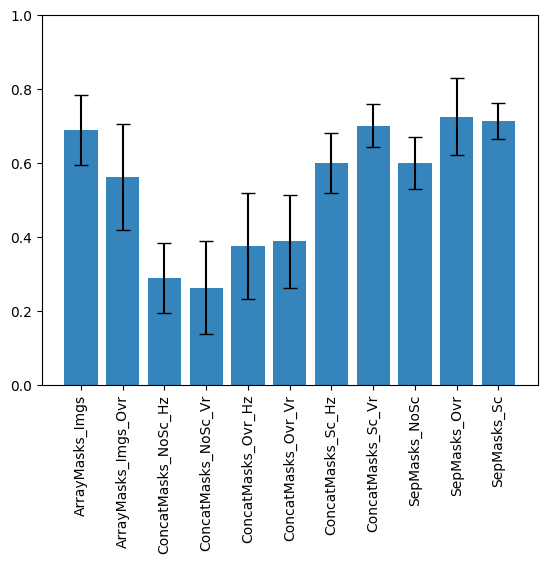

In [11]:
t = describe_da(data_da.sel(metric="pred").mean(["img_idx"]), dims_to_agg=["exp"])
display(t)
plt.bar(t["mean"].index, t["mean"], yerr=t["std"], capsize=5, alpha=0.9)
plt.ylim(bottom=0, top=1)
plt.xticks(rotation=90)
plt.show()

## Score

In [12]:
display(describe_da(data_da.sel(metric="score").mean(["img_idx"]), dims_to_agg=["var"]))
display(describe_da(data_da.sel(metric="score").mean(["img_idx", "var"]), dims_to_agg=["exp"]))

stat,mean,std,min,max
exp,,,,
cmap_as_img,3.100000,0.550000,1.95,3.7
cmap_as_names,2.904545,0.705852,1.80,3.6
cmap_as_patches,3.186364,0.451714,2.35,3.7
cmap_as_rgb,2.918182,0.773069,1.70,3.9


stat
mean    3.027273
std     0.138518
min     2.904545
max     3.186364
dtype: float64

In [13]:
describe_da(data_da.sel(metric="score").mean(["img_idx"]), dims_to_agg=["exp"])

stat,mean,std,min,max
var,,,,
ArrayMasks_Imgs,3.5625,0.149304,3.35,3.70
ArrayMasks_Imgs_Ovr,3.2375,0.340037,2.90,3.70
ConcatMasks_NoSc_Hz,2.1875,0.347311,1.70,2.50
ConcatMasks_NoSc_Vr,2.0375,0.417083,1.75,2.65
ConcatMasks_Ovr_Hz,2.4875,0.495606,1.85,3.05
ConcatMasks_Ovr_Vr,2.5875,0.322426,2.20,2.90
ConcatMasks_Sc_Hz,3.3375,0.125000,3.20,3.50
ConcatMasks_Sc_Vr,3.4875,0.062915,3.40,3.55
SepMasks_NoSc,3.2000,0.234521,2.95,3.40
